In [1]:
] activate "~/Documents/repos/SIIPExamples.jl"

Activating environment at `~/Documents/repos/SIIPExamples.jl/Project.toml`


# Production Cost Modeling with [PowerSimulations.jl](https://github.com/nrel-siip/PowerSimulations.jl)

Clayton Barrows,  
National Renewable Energy Lab,  
clayton.barrows@nrel.gov

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

## Introduction
PowerSimulations.jl supports simulations that consist of sequential optimization problems
where results from previous problems inform subsequent problems. Otherwise known as production cost modeling. Additionally, several PowerSimulations.jl supports several other types of power system simulations:
 - Unit Commitment (UC)
 - Economic Dispatch (ED)
 - Optimal Power Flow (ACOPF, DCOPF)
 - Power Flow
 - Area Control Error (ACE) & Automatic Generation Control (AGC) *coming ~May 2020*

In [2]:
] st

Project SIIPExamples v0.0.1
    Status `~/Documents/repos/SIIPExamples.jl/Project.toml`
  [9961bab8] Cbc v0.6.7
  [41994980] D3TypeTrees v0.1.1
  [a93c6f00] DataFrames v0.20.2
  [2cd47ed4] InfrastructureSystems v0.6.3
  [b6b21f68] Ipopt v0.6.1
  [2535ab7d] JSON2 v0.3.1
  [4076af6c] JuMP v0.21.2
  [98b081ad] Literate v2.4.0
  [47be7bcc] ORCA v0.3.1
  [f0f68f2c] PlotlyJS v0.13.1
  [91a5bcdd] Plots v1.1.2
  [5f7eddb3] PowerGraphics v0.3.3 #PSIMA-95 (https://github.com/Lilyhanig/PowerGraphics.jl.git)
  [e690365d] PowerSimulations v0.4.5 [`../PowerSimulations.jl`]
  [bcd98974] PowerSystems v0.16.0
  [9e3dc215] TimeSeries v0.18.0
  [0f1e0344] WebIO v0.8.13
  [ade2ca70] Dates 
  [56ddb016] Logging 
  [44cfe95a] Pkg 
  [9a3f8284] Random 
  [10745b16] Statistics 
  [8dfed614] Test 


## Dependencies

In [17]:
using SIIPExamples
using PowerSystems
using PowerSimulations
using Xpress
solver = optimizer_with_attributes(Xpress.Optimizer, "MIPRELSTOP" => 0.05, "OUTPUTLOG" => 2)
using PowerGraphics

In [4]:
using Logging
configure_logging(console_level = Logging.Error);
function load_rts()
    pkgpath = dirname(dirname(pathof(SIIPExamples)))
    include(joinpath(pkgpath,"test", "PowerSimulations_examples", "1_operations_problems.jl"));
end

load_rts (generic function with 1 method)

## Data
PowerSystems.jl supports parsers for a few standard power system data formats:
 - MATPOWER
 - PTI network files in the .raw format that follow the PSS(R)E v33
 - Tabular data (CSV)
 
The [RTS-GMLC](https://github.com/gridmod/rts-gmlc) is published as a set of .csv files. So we can use the tabular data parsing support of PowerSystems.jl to read it.

In [5]:
load_rts();
sys

System
======
Base Power: 100.0

Components
==========
Num components: 434

15×3 DataFrame. Omitted printing of 2 columns
│ Row │ ConcreteType                 │
│     │ String                       │
├─────┼──────────────────────────────┤
│ 1   │ Area                         │
│ 2   │ Bus                          │
│ 3   │ GenericBattery               │
│ 4   │ HVDCLine                     │
│ 5   │ HydroDispatch                │
│ 6   │ Line                         │
│ 7   │ LoadZone                     │
│ 8   │ PowerLoad                    │
│ 9   │ RenewableDispatch            │
│ 10  │ RenewableFix                 │
│ 11  │ TapTransformer               │
│ 12  │ ThermalStandard              │
│ 13  │ Transformer2W                │
│ 14  │ VariableReserve{ReserveDown} │
│ 15  │ VariableReserve{ReserveUp}   │

Forecasts
=========
Resolution: 60 minutes
Horizon: 8784
Initial Times: 2020-01-01T00:00:00
Interval: 0 seconds
Components with Forecasts: 139
Total Forecasts: 190

In [6]:
function make_uc_template(;kwargs...)
    uc_template = template_unit_commitment(;kwargs...)
    uc_template.devices[:Hydro] = DeviceModel(HydroEnergyReservoir, HydroDispatchRunOfRiver)
    return uc_template
end

make_uc_template (generic function with 1 method)

## Production Cost Modeling
PowerSimulations.jl is designed to flexibly build and execute sequential optimization problems. This example shows a straightforward representation of a day-ahead market clearing simulation with unit commitment. More complex examples are available in [SIIPExamples.jl](https://github.com/nrel-siip/siipexamples.jl)

### Define the problem formulation
First, we need to define how to represent each device type in the `System` using an `OperationsProblemTemplate`:

In [7]:
uc_template = make_uc_template(network = DCPPowerModel)


Operations Problem Specification

  transmission:  DCPPowerModel
  devices: 
      ILoads:
        device_type = InterruptibleLoad
        formulation = InterruptiblePowerLoad
      HydroROR:
        device_type = HydroDispatch
        formulation = HydroFixed
      Generators:
        device_type = ThermalStandard
        formulation = ThermalBasicUnitCommitment
      DistRE:
        device_type = RenewableFix
        formulation = RenewableFixed
      Hydro:
        device_type = HydroEnergyReservoir
        formulation = HydroDispatchRunOfRiver
      Loads:
        device_type = PowerLoad
        formulation = StaticPowerLoad
      RE:
        device_type = RenewableDispatch
        formulation = RenewableFullDispatch
  branches: 
      T:
        device_type = Transformer2W
        formulation = StaticTransformer
      TT:
        device_type = TapTransformer
        formulation = StaticTransformer
      L:
        device_type = Line
        formulation = StaticLine
      DC:
    

### Define the day-ahead market model
 - A `Stage` defines a model using the `OperationsProblemTemplate` and the `System` data. 
 - Users can create any number of `Stage`s along with control over how information flows inter and intra stage executions.


In [8]:
stage_def = Dict("UC" => Stage(UnitCommitmentProblem, uc_template, sys, solver))

Dict{String,Stage{UnitCommitmentProblem}} with 1 entry:
  "UC" => Stage()…

### Sequencing
The stage problem length, look-ahead, and other details surrounding the temporal sequencing
of stages are controlled using the `order`, `horizons`, and `intervals` arguments.
 - order::Dict(Int, String) : the hierarchical order of stages in the simulation
 - horizons::Dict(String, Int) : defines the number of time periods in each stage (problem length)
 - intervals::Dict(String, Dates.Period) : defines the interval with which stage problems advance after each execution

So, to define a typical day-ahead sequence, we can define a `SimulationSequence` such that day-ahead problems should represent 48 hours, advancing 24 hours after each execution (24-hour look-ahead).

In [9]:
DA_sequence = SimulationSequence(step_resolution = Hour(24),
                                    order = Dict(1 => "UC"),
                                    horizons = Dict("UC" => 24),
                                    intervals = Dict("UC" => (Hour(24), Consecutive())),
                                    ini_cond_chronology = InterStageChronology(),
                                    );

## `Simulation`
Now, we can build and execute a simulation using the `SimulationSequence` and `Stage`s
that we've defined.

In [10]:
sim = Simulation(name = "rts-test",
                steps = 2,
                stages = stage_def,
                stages_sequence = DA_sequence,
                simulation_folder = rts_dir,
                initial_time = Dates.DateTime("2020-04-07T00:00:00"))
build!(sim)

### Execute simulation

In [11]:
sim_results = execute!(sim)

Executing Step 1
Executing Step 2
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Oct  7 2019 

command line - Cbc_C_Interface -ratioGap 0.5 -logLevel 1 -solve -quit (default strategy 1)
ratioGap was changed from 0 to 0.5
Continuous objective value is 1.36059e+06 - 0.73 seconds
Cgl0004I processed model has 12968 rows, 26800 columns (5314 integer (5314 of which binary)) and 62564 elements
Cbc0045I Trying just fixing integer variables (and fixingish SOS).
Cbc0045I MIPStart solution provided values for 9060 of 5314 integer variables, 139 variables are still fractional.
Cbc0038I Full problem 12968 rows 26800 columns, reduced to 12968 rows 26800 columns - too large
Cbc0045I Mini branch and bound defined values for remaining variables in 0.11 seconds.
Cbc0045I MIPStart provided solution with cost 1.79769e+308
Cbc0012I Integer solution of 1396703.7 found by DiveCoefficient after 0 iterations and 0 nodes (8.50 seconds)
Cbc0011I Exiting as integer gap of 36113.33 less than 1e-10 or

Simulation Results Reference

Results Folder: /Users/cbarrows/Documents/repos/SIIPExamples.jl/RTS-GMLC-master/rts-test/8/results

Reference Tables

stage-UC

P__ThermalStandard: dataframe size (2, 3)

P__RenewableDispatch: dataframe size (2, 3)

Fp__Transformer2W: dataframe size (2, 3)

Spin_Up_R2__VariableReserve{ReserveUp}: dataframe size (2, 3)

Spin_Up_R3__VariableReserve{ReserveUp}: dataframe size (2, 3)

Reg_Down__VariableReserve{ReserveDown}: dataframe size (2, 3)

Spin_Up_R1__VariableReserve{ReserveUp}: dataframe size (2, 3)

parameter_P_PowerLoad: dataframe size (2, 3)

Reg_Up__VariableReserve{ReserveUp}: dataframe size (2, 3)

Flex_Down__VariableReserve{ReserveDown}: dataframe size (2, 3)

parameter_P_RenewableDispatch: dataframe size (2, 3)

parameter_P_RenewableFix: dataframe size (2, 3)

Fp__Line: dataframe size (2, 3)

On__ThermalStandard: dataframe size (2, 3)

Fp__HVDCLine: dataframe size (2, 3)

parameter_service_requirement_VariableReserve{ReserveDown}: dataframe size (2, 3)

Flex_Up__VariableReserve{ReserveUp}: dataframe size (2, 3)

Start__ThermalStandard: dataframe size (2, 3)

Stop__ThermalStandard: dataframe size (2, 3)

Fp__TapTransformer: dataframe size (2, 3)

parameter_service_requirement_VariableReserve{ReserveUp}: dataframe size (2, 3)

parameter_P_HydroDispatch: dataframe size (2, 3)

theta: dataframe size (2, 3)

stage-UC

time length: 24

## Analysis
PowerSimulations.jl natively populates simulation results in a struct of DataFrames. 


In [12]:
uc_results = load_simulation_results(sim_results, "UC")

Results
===============

P__ThermalStandard
==================
48×77 DataFrame
│ Row │ Time                │ 322_CT_6 │ 321_CC_1 │ 202_STEAM_3 │ 315_STEAM_1 │ 223_CT_4 │ 123_STEAM_2 │ 213_CT_1 │ 223_CT_6 │ 313_CC_1 │ 202_CT_2 │ 101_STEAM_3 │ 302_CT_1 │ 123_CT_1 │ 113_CT_3 │ 302_CT_3 │ 215_CT_4 │ 102_STEAM_3 │ 301_CT_4 │ 202_CT_1 │ 113_CT_2 │ 221_CC_1 │ 223_CT_5 │ 315_CT_7 │ 215_CT_5 │ 114_SYNC_COND_1 │ 323_CC_1 │ 101_STEAM_4 │ 113_CT_1 │ 223_STEAM_3 │ 318_CC_1 │ 307_CT_2 │ 213_CT_2 │ 113_CT_4 │ 315_STEAM_3 │ 118_CC_1 │ 315_CT_8 │ 302_CT_2 │ 218_CC_1 │ 213_CC_3 │ 115_STEAM_3 │ 323_CC_2 │ 101_CT_1 │ 115_STEAM_2 │ 314_SYNC_COND_1 │ 101_CT_2 │ 322_CT_5 │ 214_SYNC_COND_1 │ 315_STEAM_5 │ 207_CT_2 │ 123_STEAM_3 │ 223_STEAM_1 │ 123_CT_5 │ 301_CT_1 │ 223_STEAM_2 │ 202_STEAM_4 │ 116_STEAM_1 │ 315_STEAM_4 │ 115_STEAM_1 │ 315_STEAM_2 │ 121_NUCLEAR_1 │ 102_CT_2 │ 123_CT_4 │ 207_CT_1 │ 301_CT_3 │ 316_STEAM_1 │ 102_CT_1 │ 216_STEAM_1 │ 315_CT_6 │ 201_CT_2 │ 201_STEAM_3 │ 201_CT_1 │ 301_CT_2 │ 302_CT_4 │ 307_CT_1 │ 102_STEAM_4 │ 107_CC_1 │
│     │ DateTime            │ Float64  │ Float64  │ Float64     │ Float64     │ Float64  │ Float64     │ Float64  │ Float64  │ Float64  │ Float64  │ Float64     │ Float64  │ Float64  │ Float64  │ Float64  │ Float64  │ Float64     │ Float64  │ Float64  │ Float64  │ Float64  │ Float64  │ Float64  │ Float64  │ Float64         │ Float64  │ Float64     │ Float64  │ Float64     │ Float64  │ Float64  │ Float64  │ Float64  │ Float64     │ Float64  │ Float64  │ Float64  │ Float64  │ Float64  │ Float64     │ Float64  │ Float64  │ Float64     │ Float64         │ Float64  │ Float64  │ Float64         │ Float64     │ Float64  │ Float64     │ Float64     │ Float64  │ Float64  │ Float64     │ Float64     │ Float64     │ Float64     │ Float64     │ Float64     │ Float64       │ Float64  │ Float64  │ Float64  │ Float64  │ Float64     │ Float64  │ Float64     │ Float64  │ Float64  │ Float64     │ Float64  │ Float64  │ Float64  │ Float64  │ Float64     │ Float64  │
├─────┼─────────────────────┼──────────┼──────────┼─────────────┼─────────────┼──────────┼─────────────┼──────────┼──────────┼──────────┼──────────┼─────────────┼──────────┼──────────┼──────────┼──────────┼──────────┼─────────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼─────────────────┼──────────┼─────────────┼──────────┼─────────────┼──────────┼──────────┼──────────┼──────────┼─────────────┼──────────┼──────────┼──────────┼──────────┼──────────┼─────────────┼──────────┼──────────┼─────────────┼─────────────────┼──────────┼──────────┼─────────────────┼─────────────┼──────────┼─────────────┼─────────────┼──────────┼──────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼───────────────┼──────────┼──────────┼──────────┼──────────┼─────────────┼──────────┼─────────────┼──────────┼──────────┼─────────────┼──────────┼──────────┼──────────┼──────────┼─────────────┼──────────┤
│ 1   │ 2020-04-07T00:00:00 │ 0.0      │ 1.7      │ 0.3         │ 0.0         │ 0.0      │ 0.62        │ 0.0      │ 0.0      │ 1.7      │ 0.0      │ 0.3         │ 0.0      │ 0.0      │ 0.0      │ 0.0      │ 0.0      │ 0.3         │ 0.0      │ 0.0      │ 0.0      │ 1.7      │ 0.0      │ 0.0      │ 0.0      │ 0.0             │ 0.0      │ 0.3         │ 0.0      │ 1.4         │ 0.0      │ 0.0      │ 0.0      │ 0.0      │ 0.0         │ 0.0      │ 0.0      │ 0.0      │ 0.0      │ 0.0      │ 0.62        │ 0.0      │ 0.0      │ 0.0         │ 0.0             │ 0.0      │ 0.0      │ 0.0             │ 0.0         │ 0.0      │ 1.4         │ 0.62        │ 0.0      │ 0.0      │ 0.62        │ 0.3         │ 0.62        │ 0.0         │ 0.0         │ 0.0         │ 4.0           │ 0.0      │ 0.0      │ 0.0      │ 0.0      │ 0.62        │ 0.0      │ 0.62        │ 0.0      │ 0.0      │ 0.3         │ 0.0      │ 0.0      │ 0.0      │ 0.0      │ 0.3         │ 0.0      │
│ 2   │ 2020-04-07T01:00:00 │ 0.0      │ 1.7      │ 0.3         │ 0.0        

## Plotting
The (new) [PowerGraphics.jl](https://github.com/nrel-siip/powergraphics.jl) package has some standard plotting capabilitites based on the results produduced by PowerSimulations.jl

In [15]:
#plotlyjs() # for interactive plots
gr() # for static plots

Plots.GRBackend()

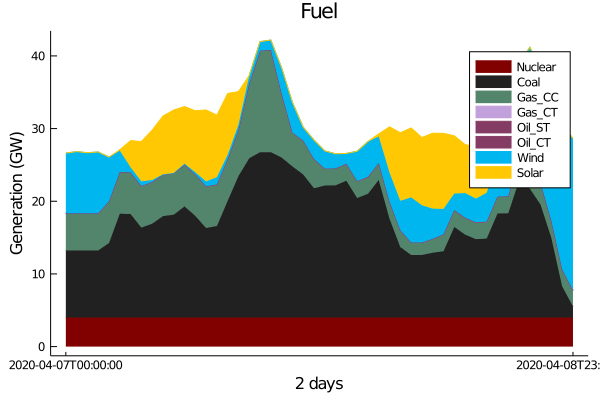

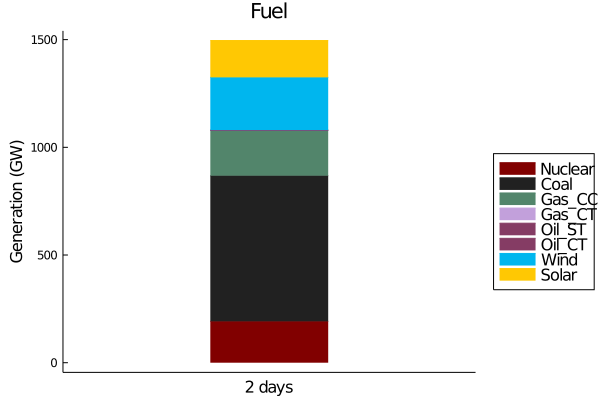

2-element Array{Plots.Plot{Plots.GRBackend},1}:
 Plot{Plots.GRBackend() n=8}
 Plot{Plots.GRBackend() n=8}

In [16]:
fuel_plot(uc_results, sys)

## What's Next?
 - ACE & AGC *~May 2020*
 - Capacity Expansion Modeling *~September 2020*
 - Power system dynamics *-Setember 2020*
 
 [__PowerSystems.jl__](https://github.com/nrel-siip/powersystems.jl)   
 [__PowerSimulations.jl__](https://github.com/nrel-siip/powersimulations.jl)   
 [__PowerGraphics.jl__](https://github.com/nrel-siip/powergraphics.jl)  
 [__SIIPExamples.jl__](https://github.com/nrel-siip/siipexamples.jl)
 
 Contact: clayton.barrows@nrel.gov  @claytonpbarrows (GitHub, gitter, slack, twitter)